# Let's Train GLaM





### Configure the machine and install packages


In [1]:
from typing import Literal

import os

#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax

platform : Literal["darwin", "colab", "cuda", "tpu"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"
    if any(d.platform == "tpu" for d in devices):
        platform = "tpu"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on tpu


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/home/vikram/jaxpt/src


In [3]:
import os


import warnings

import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)

devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Set up device mesh

DATA_DIMS = 2
MODEL_DIMS = 4

mesh = jax.sharding.Mesh(np.reshape(jax.devices(), (DATA_DIMS, MODEL_DIMS)),
                            ["data", "model"])

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.4
Available devices: 8
Device: TPU_0(process=0,(0,0,0,0)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_1(process=0,(0,0,0,1)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_2(process=0,(1,0,0,0)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_3(process=0,(1,0,0,1)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_4(process=0,(0,1,0,0)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_5(process=0,(0,1,0,1)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_6(process=0,(1,1,0,0)), Memory: 15853.984375,  Used: 0.015625
Device: TPU_7(process=0,(1,1,0,1)), Memory: 15853.984375,  Used: 0.015625


/tmp/ipykernel_20341/2621405116.py:26: UserWarning: not using gpu. Using tpu
  warnings.warn(f"not using {requested_device}. Using {device}")


2.68 ms ± 26.7 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the Mobile-LLM model and perform a sanity check

In [4]:
from datetime import datetime
import random
import string

from jaxpt.checkpointers import save_checkpoint, load_checkpoint, load_checkpoint_from_gcloud

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "cuda":
  output_dir = Path("/home/ubuntu/alpha_training_runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent  / "alpha_training_runs" # Local setup

Run: run_20250617_jtiepr


In [6]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import GLaM, GLaM_Config
from jaxpt.models.mobile_llm import from_hf_pretrained
from jaxpt.utils import count_params, create_sharded_model

from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = GLaM_Config(dtype=jnp.bfloat16, \
                     n_layer=2,
                     sdpa_implementation="cudnn" if device=="gpu" else "xla",)
nnx.display(config)


with mesh:
    m = create_sharded_model(GLaM, config, rngs)
    #m = load_checkpoint_from_gcloud(Mobile_LLM, config, output_dir, "alpha_training_runs", "run_20250521_pakugd", "9000", rngs)
    #m = load_checkpoint(Mobile_LLM, output_dir, config, "run_20250521_pakugd", 9000, rngs)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)

    print(f"Parameter Count: {total_params:,}")
    nnx.display(state)

    jax.debug.visualize_array_sharding(m.h[0].mlp.c_proj.kernel.value)

    #tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    #completions = generate_completions(m, enc=tokenizer, num_completions=5,
    #                                max_length=21,
    #                                prefix="Ducks quack, donkeys bray, cats mew, horses")
    #for completion in completions:
    #    print(completion)

Parameter Count: 352,472,832


                                    
                                    
                                    
                                    
                                    
 TPU 0,4  TPU 1,5  TPU 2,6  TPU 3,7 
                                    
                                    
                                    
                                    
                                    

### Configure Training Run

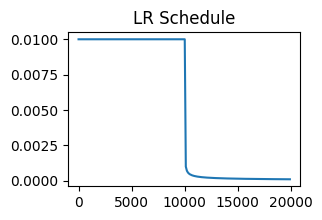

tokens/batch: 32,768
block size: 1024
sub-batch size: 2
no. gradient accumulation steps: 2
effective batch size per device:  4
effective batch size: 32
max steps: 20,000


In [55]:
import dataclasses
from functools import partial

import matplotlib.pyplot as plt

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**15
  mB: int = 2
  T: int = 1024
  max_steps: int = 20_000
  max_lr: float = 1e-2
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 10_000
  print_interval: int = 20
  eval_interval: int = 1000
  checkpoint_interval: int = 1000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

def inverse_sqrt_decay_schedule(warmup_steps, max_lr, step):
  return jnp.where(step+1 < warmup_steps,
                    max_lr,
                    max_lr * (step+1 - warmup_steps) ** -0.5)

lr_schedule = partial(inverse_sqrt_decay_schedule,
                      trconf.warmup_steps,
                      trconf.max_lr)

steps = range(0, trconf.max_steps, 100)
total_schedule = [ lr_schedule(step) for step in steps ]

plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)

tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adafactor(lr_schedule,
    decay_rate=0.8)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0


print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [57]:
import os

from jaxpt.dataloaders import HuggingfaceDataLoader

train_dl = HuggingfaceDataLoader(batch_size=trconf.mB,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)



Initializing tokenizer HuggingFaceTB/SmolLM-135M


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/234 [00:00<?, ?it/s]

HuggingfaceDataLoader initialized:
------------------------
label:          train
shards:         0
shard size:     299
batch size:     2
block size:     1024
device rank:    1
------------------------


In [58]:
from jaxpt.utils import append_to_csv

# Create log dir
log_dir = output_dir / m.config.name / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0

Log directory: /home/vikram/jaxpt/alpha_training_runs/GLaM/logs


(0.01+0j)
Evaluation TBD999999776482582+0j) | loss: 6.6641 | time: 15582.47ms | tokens processed: 32,768 | tok/sec: 2,102.88
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)(0.009999999776482582+0j) | loss: 7.7426 | time: 769.85ms | tokens processed: 688,128 | tok/sec: 42,563.91
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)(0.009999999776482582+0j) | loss: 6.3320 | time: 777.62ms | tokens processed: 1,343,488 | tok/sec: 42,139.01
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)
(0.01+0j)(0.009999999776482582+0j) | loss: 6.6059 | time: 785

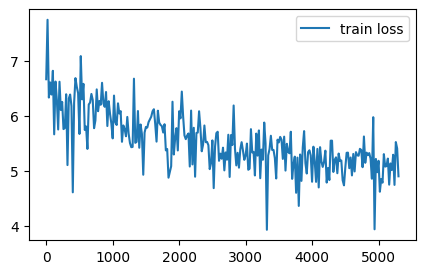

In [59]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import train_step

data_sharding = NamedSharding(mesh, PartitionSpec("data", None))

with mesh:
  m.train()
  try:
    while step < trconf.max_steps:
      start = time.time()
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), data_sharding)
      target = jax.device_put(target.squeeze(), data_sharding)
      avg_loss, avg_grads = train_step(m, optimizer, batch, target)
      avg_loss.block_until_ready()
      # compute stats
      avg_loss = jax.device_get(avg_loss)
      avg_loss = jnp.float32(avg_loss)
      lr = lr_schedule(step)
      print(lr)
      iter_time = time.time() - start
      sub_step_time = iter_time / trconf.grad_accumulation_steps
      tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
      tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

      if step % trconf.print_interval == 0:
        train_losses.append((step, avg_loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr} | "
              f"loss: {avg_loss:0.4f} | "
              f"time: {iter_time*1000:0.2f}ms | "
              f"tokens processed: {tokens_processed:,} | "
              f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
      if step % trconf.eval_interval == 0:
        print("Evaluation TBD")
        # save_checkpoint(m, run_dirname, step)
      step += 1

  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  plt.figure(figsize=(5, 3))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()


In [ ]:
save_checkpoint(m, run_dirname, step)

In [ ]:
import logging

from jaxpt.infer import generate_chat

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Prevent logs from being propagated to the root logger
logger.propagate = False
# Remove all existing handlers
logger.handlers.clear()
# Create a console handler
console_handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
if not logger.handlers:
    logger.addHandler(console_handler)

question = "What is the capital of the Indian state of Maharashtra?"

m.eval()
generate_chat(m, enc=tokenizer, format="chatml", question=question, logger=logger)

Model: Maharashtra

